In [87]:
from wrf import getvar, interplevel, latlon_coords, to_np, CoordPair, vertcross, interpline
from netCDF4 import Dataset
import glob
import numpy as np
import wrf_src
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd

from scipy.interpolate import griddata

In [2]:
plt.rcParams.update({
    "font.size": 16,
    "font.weight": "bold",
   # "font.family": "monospace"
})

In [83]:
infolder = '/nas/rstor/akumar/USA/PhD/Objective01/Hurricane_Harvey/WRF_Harvey_V2/WRF_Simulations/WRF_FNL_2512/pre/WRF433_HR/test/em_real/'

files = sorted(glob.glob(infolder + 'wrfout_d01_2017-08-27*'))

# print(files)


In [121]:
ncdata = Dataset(files[0])

wspd = getvar(ncdata, 'wspd_wdir').sel(wspd_wdir='wspd')
pressure = wrf_src.add_coords(getvar(ncdata, 'pressure'), rename=True)
height = wrf_src.add_coords(getvar(ncdata, 'height'), rename=True)

wspd_500 = wrf_src.add_coords(interplevel(wspd, pressure, 500), rename=True)

ter = getvar(ncdata, "ter")


In [45]:
start_point = CoordPair(lat=27, lon=-100)
end_point = CoordPair(lat=31.5, lon=-94)

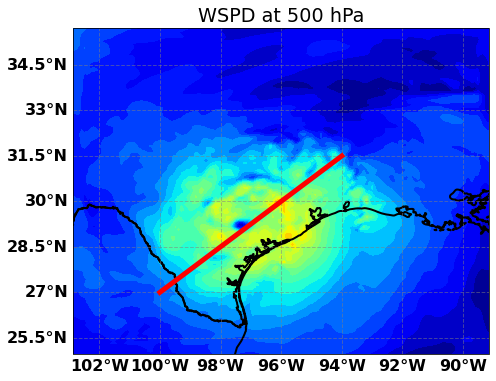

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axs.contourf(wspd_500.longitudes, wspd_500.latitudes, wspd_500, levels=np.arange(0, 50, 2), cmap='jet')

# Plot cross section line
axs.plot([start_point.lon, end_point.lon], [start_point.lat, end_point.lat], 'r-', linewidth=5)

axs.set_title('WSPD at 500 hPa')
wrf_src.plot_coast(axs, linewidth=2)
plt.show()


## Vertical Cross Section on Pressure and Height Coordinates

In [30]:
wspd_cross_pressure = vertcross(wspd, pressure, wrfin=ncdata, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

wspd_cross_height = vertcross(wspd, height, wrfin=ncdata, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

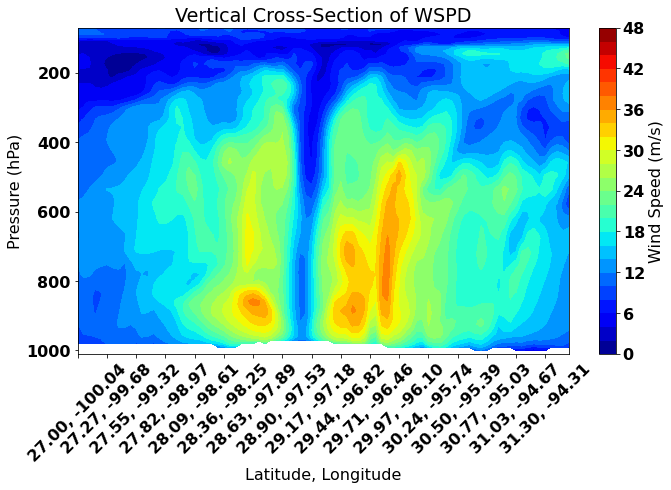

In [126]:
vertical_coords = wspd_cross_pressure.vertical
cross_coords = wspd_cross_pressure.xy_loc


ter_line = interpline(ter, wrfin=ncdata, start_point=start_point,
                      end_point=end_point)

fig, ax = plt.subplots(1, 1, figsize=(11, 6))
cf = ax.contourf(np.arange(0, len(cross_coords)), vertical_coords, wspd_cross_pressure.values, levels=np.arange(0, 50, 2), cmap='jet')
ax.set_xlabel('WSPD (m/s)')
ax.set_ylabel('Pressure (hPa)')
ax.set_title('Vertical Cross-Section of WSPD')
plt.gca().invert_yaxis()  

# ax.plot(np.arange(0, len(cross_coords)), ter_line, 'k-', linewidth=2)

# Add colorbar
plt.colorbar(cf, ax=ax, label='Wind Speed (m/s)')

coord_pairs = to_np(wspd_cross_pressure.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, )
ax.set_xlabel('Latitude, Longitude')

plt.show()

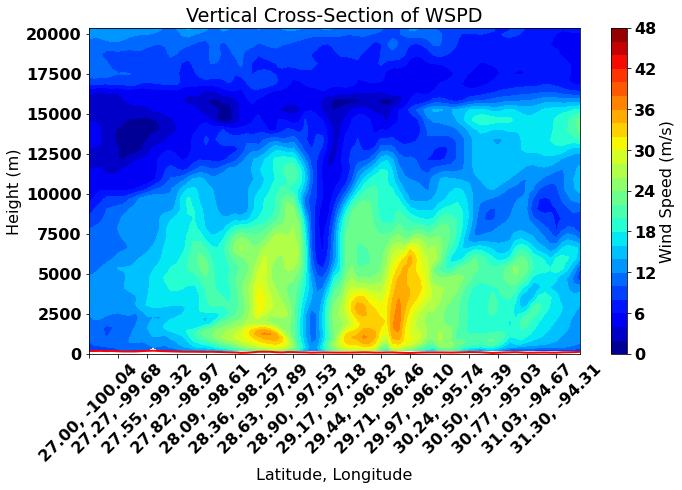

In [129]:
vertical_coords = wspd_cross_height.vertical
cross_coords = wspd_cross_height.xy_loc

fig, ax = plt.subplots(1, 1, figsize=(11, 6))
cf = ax.contourf(np.arange(0, len(cross_coords)), vertical_coords, wspd_cross_height.values, levels=np.arange(0, 50, 2), cmap='jet')
ax.set_xlabel('WSPD (m/s)')
ax.set_ylabel('Height (m)')
ax.set_title('Vertical Cross-Section of WSPD')
ax.plot(np.arange(0, len(cross_coords)), ter_line, 'r-', linewidth=2)

# Add colorbar
plt.colorbar(cf, ax=ax, label='Wind Speed (m/s)')

coord_pairs = to_np(wspd_cross_pressure.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, )
ax.set_xlabel('Latitude, Longitude')

plt.show()

## Hovmöller diagram

In [52]:
slp_cross_time_list = []

for file in files:

    ncdata = Dataset(file)
    slp = getvar(ncdata, 'slp')

    slp_cross_time = interpline(slp, wrfin=ncdata, start_point=start_point, end_point=end_point, latlon=True, meta=True)
    slp_cross_time_list.append(slp_cross_time)

slp_cross_time_list = np.array(slp_cross_time_list)
slp_cross_time_xr = xr.concat(slp_cross_time_list, dim='time')

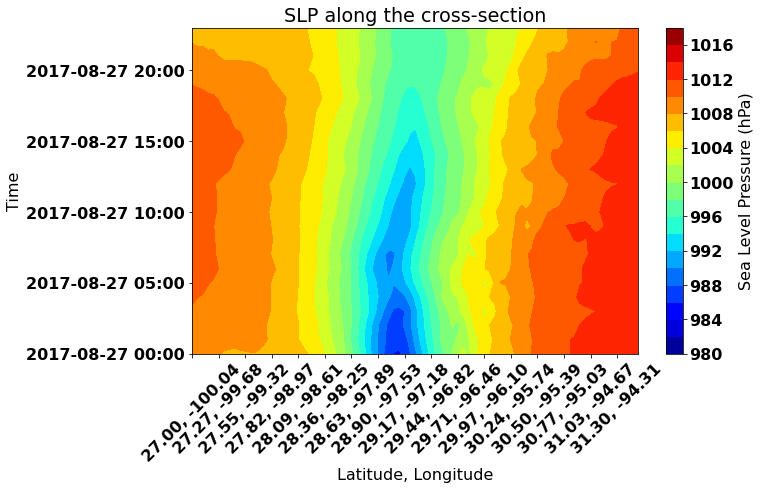

In [82]:
xy_loc = slp_cross_time_xr.xy_loc
time = slp_cross_time_xr.Time

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cf = ax.contourf(np.arange(0, len(xy_loc)), np.arange(0, len(time)), slp_cross_time_xr.values, 
            levels=np.arange(980, 1020, 2), cmap='jet')

ax.set_yticks(np.arange(0, len(time), 5))
ax.set_yticklabels([pd.Timestamp(t).strftime('%Y-%m-%d %H:%M') for t in time[::5].values], )

ax.set_xticks(np.arange(0, len(xy_loc), 5))
ax.set_xticklabels([pair.latlon_str(fmt="{:.2f}, {:.2f}") for pair in to_np(xy_loc)[::5]], rotation=45)

ax.set_xlabel('Latitude, Longitude')
ax.set_ylabel('Time')
ax.set_title('SLP along the cross-section')

# Add colorbar
plt.colorbar(cf, ax=ax, label='Sea Level Pressure (hPa)')

plt.show()


## Hovmöller diagram using xarray

In [118]:
num_points = 50
lats_cross = np.linspace(start_point.lat, end_point.lat, num_points)
lons_cross = np.linspace(start_point.lon, end_point.lon, num_points)


slp_cross_time_list, time_list = [], []

for file in files:

    ncdata = Dataset(file)
    slp = wrf_src.add_coords(getvar(ncdata, 'slp'), rename=True)

    lat_mesh, lon_mesh = np.meshgrid(slp.latitudes, slp.longitudes)

    slp_cross_time = griddata((lat_mesh.flatten(), lon_mesh.flatten()), slp.T.values.flatten(), (lats_cross, lons_cross), method='linear')

    slp_cross_time_list.append(slp_cross_time)
    time_list.append(slp.Time.values)

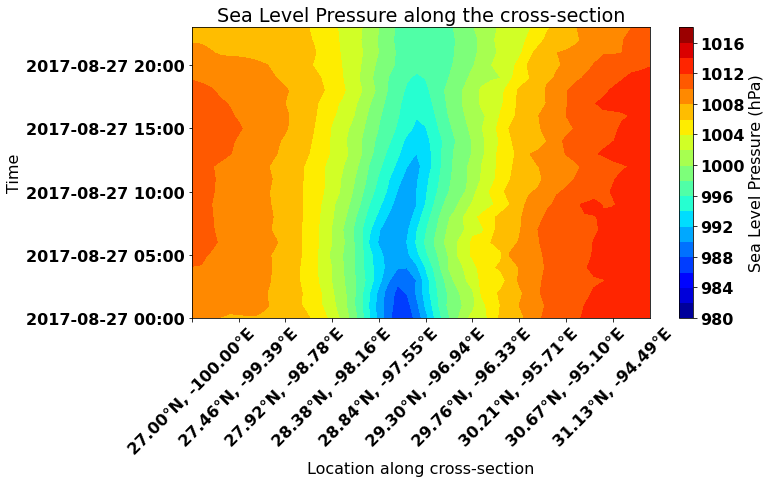

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))

# Create contour plot
cf = ax.contourf(np.arange(0, len(lons_cross)), np.arange(0, len(time_list)), 
                 np.array(slp_cross_time_list), cmap='jet', levels=np.arange(980, 1020, 2))

# Set labels and title
ax.set_xlabel('Location along cross-section')
ax.set_ylabel('Time')
ax.set_title('Sea Level Pressure along the cross-section')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(0, len(lons_cross), 5))
ax.set_xticklabels([f'{lat:.2f}°N, {lon:.2f}°E' 
                    for lat, lon in zip(lats_cross[::5], lons_cross[::5])], rotation=45)

ax.set_yticks(np.arange(0, len(time_list), 5))
ax.set_yticklabels([pd.Timestamp(t).strftime('%Y-%m-%d %H:%M') 
                    for t in time_list[::5]], rotation=0)

plt.colorbar(cf, ax=ax, label='Sea Level Pressure (hPa)')

plt.tight_layout()
plt.show()